# Entrega
## Intro
Esta notebook se utiliza para la entrega del challange. 
Explica el proceso de manera simplificada de 
- limpieza y transformacion de los datos
- entregar el modelo seleccionado, 
- eligiendo los mejores hiperparámetros
- guardando el resultado en /data/results

No se realiza un analisis, en el repositorio luego dejaré un minimo análisis.

Hay formas de asegurar la reproducibilidad de los resultados utilizando seeds (o random_state) para que el resultado sea el mismo siempre. (De todas formas, los resultados podrían diferir un poco...)

- https://machinelearningmastery.com/reproducible-machine-learning-results-by-default/
- https://machinelearningmastery.com/randomness-in-machine-learning/
- https://towardsdatascience.com/exploring-optuna-a-hyper-parameter-framework-using-logistic-regression-84bd622cd3a5


______________
## Limpieza y Transformación
- El código se encuentra en funciones que realizan cambios en el dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler


SEED = 42
np.random.seed(SEED)


In [3]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

In [4]:
# methods used in clean & transform stage

def train_ordinal(df, enc_columns):
    """ Train an ordinal encoder from sklearn
    """
    enc = OrdinalEncoder()
    enc.fit(df[enc_columns].to_numpy())
    
    return enc

def transform_ordinal(df, enc, enc_columns):
    """ Transform and Apply an ordinal encoder from sklearn
    """
    df[enc_columns] = enc.transform(df.loc[:, enc_columns])
    df[enc_columns] = df.loc[:, enc_columns].astype('category')
    

def train_ohe(df, ohe_columns):
    """ Train a one hot encoder from sklearn
    """
    ohe = OneHotEncoder()
    ohe.fit(df[ohe_columns])
    return ohe

def transform_one_hot(df, ohe, ohe_columns):
    """ Transform and Apply an one-hot encoder from sklearn
    """
    df.loc[:, ohe.get_feature_names(ohe_columns)] = ohe.transform(df[ohe_columns]).toarray()
    df.drop(columns=ohe_columns, inplace=True)


def train_stdscaler(df, columns):
    """ Train a scaler from sklearn. MixMax gives better performance than StandardScaler
    """
    scaler = MinMaxScaler()
    scaler.fit(df[columns])
    return scaler

def transform_stdscaler(df, scaler, columns):
    """ Transform and Apply scaler from sklearn
    """
    df[columns] = scaler.transform(df[columns])
    

def sum_duration_columns(df):
    """ From all *_Duration columns, it are sum and result in a new column Total
    """
    duration_columns = df.columns.str.contains("Duration")
    duration_columns_str = df.columns[duration_columns]
    pages_names = duration_columns_str.str.replace('_Duration', '')
    df['Total_Duration'] = df.loc[:, duration_columns_str].sum(axis=1)
    df["Total"] = df.loc[:, pages_names].sum(axis=1)

def avg_duration_per_page(df):
    """ From all *_Duration columns, add a avg duration time per page
    """
    duration_columns = df.columns.str.contains("Duration")
    duration_columns_str = df.columns[duration_columns]
    pages_names = duration_columns_str.str.replace('_Duration', '')
    for page, duration in zip(pages_names, duration_columns_str):
        df[page+"_Duration_AVG"]= (df[duration] / df[page]).fillna(-1)


In [5]:
# transforming TRAIN set

# 1st option
enc_columns=["Month", "TrafficType", "Browser"]
enc = train_ordinal(train, enc_columns)
transform_ordinal(train, enc, enc_columns)

ohe_columns = ["SpecialDay", "OperatingSystems", "Region", "VisitorType", "Weekend"]
ohe = train_ohe(train, ohe_columns)
transform_one_hot(train, ohe, ohe_columns)

sum_duration_columns(train)
avg_duration_per_page(train)

stdscaler_columns = ["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]

scaler = train_stdscaler(train, stdscaler_columns)
transform_stdscaler(train, scaler, stdscaler_columns)

In [6]:
# transform TEST set 
transform_ordinal(test, enc, enc_columns)
transform_one_hot(test, ohe, ohe_columns)
sum_duration_columns(test)
transform_stdscaler(test, scaler, stdscaler_columns)

sum_duration_columns(test)
avg_duration_per_page(test)



_______________________
## Model: Selecting, Training and Tuning


In [7]:
import pandas as pd

In [8]:
import lightgbm as lgb
import optuna

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer

from functools import partial

In [10]:
metric = partial(f1_score, average='macro')
score = make_scorer(f1_score, average='macro')

In [11]:
X, y = train.loc[:, ~train.columns.isin(['revenue', "id"])], train.revenue
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=SEED)

### Selecting model

In [12]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingClassifier
import warnings
warnings.simplefilter('ignore')

clf1 = lgb.LGBMClassifier(random_state=SEED)
clf2 = KNeighborsClassifier()
clf3 = RandomForestClassifier(random_state=SEED)

lr = LogisticRegression(random_state=SEED)
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['LGB1',  'KNN', 'RF', 'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, cv=3, scoring=score)
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))
    

3-fold cross validation:

Accuracy: 0.7967 (+/- 0.0049) [LGB1]
Accuracy: 0.6650 (+/- 0.0032) [KNN]
Accuracy: 0.7798 (+/- 0.0037) [RF]
Accuracy: 0.7798 (+/- 0.0037) [StackingClassifier]


probando algunos modelos, nos damos cuenta que lgb o rf pueden ser una buena opción.

En este caso voy a elegir RF, pero podría agregar un branch con `trial.suggest_categorical("model", ["lgb", "rf"])`

In [14]:
def objective_challenge(trial: optuna.trial.Trial):

    param = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "n_estimators":trial.suggest_int("n_estimators", 50, 400, step=50),
        "max_depth": trial.suggest_int("max_depth", 9, 27, log=True),
        "min_samples_split": trial.suggest_int('min_samples_split', 5, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 60, step=1),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "class_weight":trial.suggest_categorical("class_weight",["balanced_subsample"]),
        "random_state": trial.suggest_int("random_state", SEED, SEED),
    }
    
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "F1_MACRO", "validation")

    gbm = RandomForestClassifier(**param, verbose=0)
    
    f1_cross = cross_val_score(
        gbm, 
        pd.concat([X_train, X_val]), pd.concat([y_train, y_val]), 
        n_jobs=-1,
        cv=StratifiedKFold(3), 
        scoring=score,
#         fit_params={
#             **fit_params, 
# #             "early_stopping_rounds":15, 
#             "callbacks":[pruning_callback]
#         }
    )
    
    return np.mean(f1_cross)
    

In [15]:
# creamos un study de optuna para buscar los mejores parámetros de lightgbm
study = optuna.create_study(
    study_name="006-study-challenge",
    storage="sqlite:///../006-study-challenge.db",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=20, n_warmup_steps=30), # this acts as a early_stopping
    direction="maximize",
    load_if_exists=True
)

study.optimize(objective_challenge, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-02-08 19:39:14,729] A new study created in RDB with name: 006-study-challenge
[I 2021-02-08 19:39:19,544] Trial 0 finished with value: 0.7827459472637629 and parameters: {'criterion': 'gini', 'n_estimators': 200, 'max_depth': 26, 'min_child_samples': 76, 'min_samples_leaf': 21, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced_subsample', 'random_state': 42}. Best is trial 0 with value: 0.7827459472637629.
[I 2021-02-08 19:39:24,759] Trial 1 finished with value: 0.7710833392467813 and parameters: {'criterion': 'gini', 'n_estimators': 350, 'max_depth': 9, 'min_child_samples': 92, 'min_samples_leaf': 53, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced_subsample', 'random_state': 42}. Best is trial 0 with value: 0.7827459472637629.
[I 2021-02-08 19:39:26,509] Trial 2 finished with value: 0.7798987976976947 and parameters: {'criterion': 'gini', 'n_estimators': 100, 'max_depth': 20, 'min_child_samples': 34, 'min_samples_leaf': 38, 'max_featu

Number of finished trials: 100
Best trial:
  Value: 0.8215793019808597
  Params: 
    bootstrap: False
    class_weight: balanced_subsample
    criterion: entropy
    max_depth: 21
    max_features: sqrt
    min_child_samples: 5
    min_samples_leaf: 3
    n_estimators: 250
    random_state: 42


In [16]:
print("Best params", trial.params)

Best params {'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 21, 'max_features': 'sqrt', 'min_child_samples': 5, 'min_samples_leaf': 3, 'n_estimators': 250, 'random_state': 42}


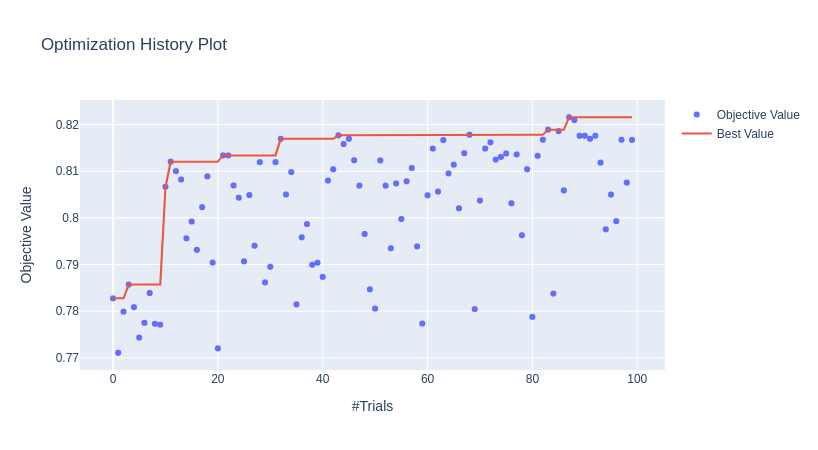

In [23]:
# jupyter lab needs plotly extension widget
# https://github.com/plotly/plotly.py#jupyterlab-support-python-35
# https://colab.research.google.com/github/optuna/optuna/blob/master/examples/quickstart.ipynb#scrollTo=Jd4Ew4Kt_IIm
optuna.visualization.plot_optimization_history(study)
# optuna.visualization.plot_param_importances(study)
# optuna.visualization.matplotlib.plot_param_importances(study)


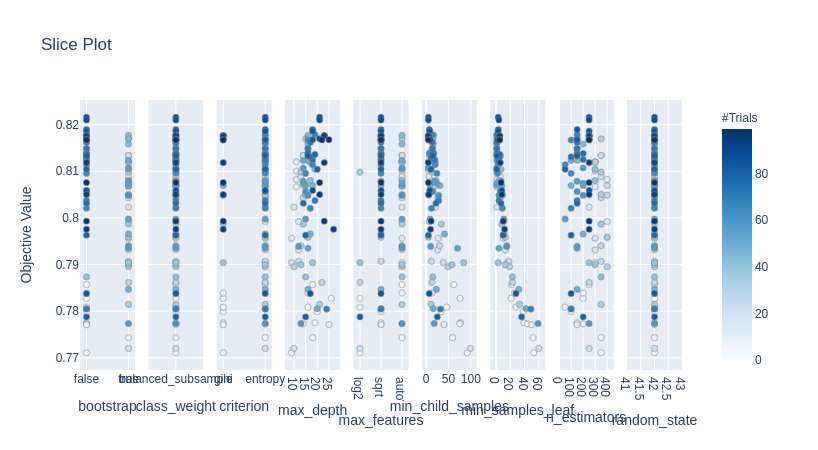

In [24]:
optuna.visualization.plot_slice(study)

In [20]:
records = []
for t in study.get_trials():
    records.append({**t.params, "f1_score":t.values[0] if t.values is not None else 0})

pd.DataFrame.from_records(records).sort_values(by="f1_score", ascending=False)

,criterion,n_estimators,max_depth,min_child_samples,min_samples_leaf,max_features,bootstrap,class_weight,random_state,f1_score
87,entropy,250,21,5,3,sqrt,False,balanced_subsample,42,0.821579
88,entropy,250,21,5,4,sqrt,False,balanced_subsample,42,0.820989
83,entropy,150,18,7,3,sqrt,False,balanced_subsample,42,0.818926
85,entropy,250,18,8,3,sqrt,False,balanced_subsample,42,0.818603
68,entropy,150,19,14,1,sqrt,False,balanced_subsample,42,0.817834
...,...,...,...,...,...,...,...,...,...,...
8,entropy,200,14,75,44,auto,False,balanced_subsample,42,0.777284
9,gini,150,25,40,50,sqrt,False,balanced_subsample,42,0.777101
5,entropy,350,18,59,52,auto,True,balanced_subsample,42,0.774331
20,entropy,250,10,99,60,log2,True,balanced_subsample,42,0.772018


In [21]:
study.trials_dataframe()[lambda r: r.value.notna()].sort_values(by='value', ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_bootstrap,params_class_weight,params_criterion,params_max_depth,params_max_features,params_min_child_samples,params_min_samples_leaf,params_n_estimators,params_random_state,state
87,87,0.821579,2021-02-08 19:46:48.016772,2021-02-08 19:46:55.951757,0 days 00:00:07.934985,False,balanced_subsample,entropy,21,sqrt,5,3,250,42,COMPLETE
88,88,0.820989,2021-02-08 19:46:56.037683,2021-02-08 19:47:03.758382,0 days 00:00:07.720699,False,balanced_subsample,entropy,21,sqrt,5,4,250,42,COMPLETE
83,83,0.818926,2021-02-08 19:46:23.521625,2021-02-08 19:46:29.061674,0 days 00:00:05.540049,False,balanced_subsample,entropy,18,sqrt,7,3,150,42,COMPLETE
85,85,0.818603,2021-02-08 19:46:32.649700,2021-02-08 19:46:40.676517,0 days 00:00:08.026817,False,balanced_subsample,entropy,18,sqrt,8,3,250,42,COMPLETE
68,68,0.817834,2021-02-08 19:45:10.789686,2021-02-08 19:45:16.641991,0 days 00:00:05.852305,False,balanced_subsample,entropy,19,sqrt,14,1,150,42,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,8,0.777284,2021-02-08 19:39:44.362403,2021-02-08 19:39:48.294433,0 days 00:00:03.932030,False,balanced_subsample,entropy,14,auto,75,44,200,42,COMPLETE
9,9,0.777101,2021-02-08 19:39:48.347973,2021-02-08 19:39:50.615243,0 days 00:00:02.267270,False,balanced_subsample,gini,25,sqrt,40,50,150,42,COMPLETE
5,5,0.774331,2021-02-08 19:39:32.904805,2021-02-08 19:39:38.421461,0 days 00:00:05.516656,True,balanced_subsample,entropy,18,auto,59,52,350,42,COMPLETE
20,20,0.772018,2021-02-08 19:40:57.428362,2021-02-08 19:41:01.269632,0 days 00:00:03.841270,True,balanced_subsample,entropy,10,log2,99,60,250,42,COMPLETE


In [36]:
# Estos son los parámetros que me dieron el resultado ganador
# best rf params
rf_params = {
    'bootstrap': False, 
    'class_weight': 'balanced_subsample', 
    'criterion': 'entropy', 
    'max_depth': 21, 
    'max_features': 'sqrt', 
    'min_samples_split': 5, 
    'min_samples_leaf': 3, 
    'n_estimators': 250, 
    'random_state': 42
}


In [37]:
# pero voy a sobreescribirlos con los de optuna
trial.params 

{'bootstrap': False,
 'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_depth': 21,
 'max_features': 'sqrt',
 'min_child_samples': 5,
 'min_samples_leaf': 3,
 'n_estimators': 250,
 'random_state': 42}

In [38]:
clf = RandomForestClassifier(**rf_params)

In [39]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       criterion='entropy', max_depth=21, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=5,
                       n_estimators=250, random_state=42)

In [41]:
# print(classification_report(y_train, clf.predict(X_train)))
# print(classification_report(y_val, clf.predict(X_val)))
# print(classification_report(y_test, clf.predict(X_test)))

print("Train: ", metric(y_train, clf.predict(X_train)), "Validation: ", metric(y_val, clf.predict(X_val)))
print("Test: ", metric(y_test, clf.predict(X_test)))

Train:  0.984397431248913 Validation:  0.8216827799925756
Test:  0.7935037797191449


_________________

## Submition


In [42]:
test_pred = test.loc[:, ~test.columns.isin(['revenue', "id"])]

clf.fit(X, y)

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       criterion='entropy', max_depth=21, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=5,
                       n_estimators=250, random_state=42)

In [45]:
submit = clf.predict(test_pred)

In [46]:
from datetime import datetime
get_date = lambda : datetime.now().strftime("%Y%m%d_%H%M%S")

In [47]:
date_part = get_date()

In [48]:
pd.DataFrame({"id":test.id, "revenue":submit}).to_csv(f'../data/results/006-{date_part}_rf.csv', index=False)
pd.DataFrame([clf.get_params()]).to_csv(f'../data/results/006-{date_part}_params_rf.csv', index=False)

______________
## Model interpretation
TODO: 
- https://towardsdatascience.com/decrypting-your-machine-learning-model-using-lime-5adc035109b5
- https://christophm.github.io/interpretable-ml-book/interpretability.html
- https://github.com/slundberg/shap


In [ ]:
https://towardsdatascience.com/decrypting-your-machine-learning-model-using-lime-5adc035109b5